<a href="https://colab.research.google.com/github/AravindhanV/GrocerySalesForecasting/blob/master/Grocery_Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sales Forecaster
###A deep learning model that uses Recurrent Neural Networks (RNN) for time series forecasting.

####The following steps were involved in making the model
- Obtain Dataset
- Preprocess the data for time series analysis
- Build the model
- Train the model
- Test the model

##Obtaining the Dataset
***
####Setup Kaggle  API key and download dataset

In [ ]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle

In [ ]:
!sudo apt-get install p7zip
!kaggle competitions download -c favorita-grocery-sales-forecasting
# !7za e train*7z
!7za e test*7z
!7za e holiday*7z
!7za e sample*7z
!7za e item*7z
!7za e oil*7z
!7za e store*7z
!7za e transaction*7z

####Importing Libraries

In [ ]:
import datetime
import pandas as pd
import random
import feather
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
from keras import callbacks
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


####Import dataset from feather

In [ ]:
#Mounting Google Drive directory
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp drive/My\ Drive/*.file .

In [ ]:
train = feather.read_dataframe('train.file')
# test = feather.read_dataframe('test.file')

In [ ]:
train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,month,year,no
0,0,1,25,103665,7.0,False,1,2013,0
1,1,1,25,105574,1.0,False,1,2013,0
2,2,1,25,105575,2.0,False,1,2013,0
3,3,1,25,108079,1.0,False,1,2013,0
4,4,1,25,108701,1.0,False,1,2013,0


####Filter dataset

In [ ]:
#Return the month number where Jan 2013 = 1, Feb 2013 = 2 and so on
def getmonth(m,y,r):
    if(r%100000==0):
        print(r)
    n = (y-2013)*12
    n += (m-1)
    return n

In [ ]:
#Filter dataset to select one item from one shop
check = train.loc[train['store_nbr'] == 5]
check = check.loc[check['item_nbr'] == 105575]
check = check.sort_values(["year","month","date"]).reset_index().drop("index",axis=1)
len(check)

1676

####Visualizing the Data

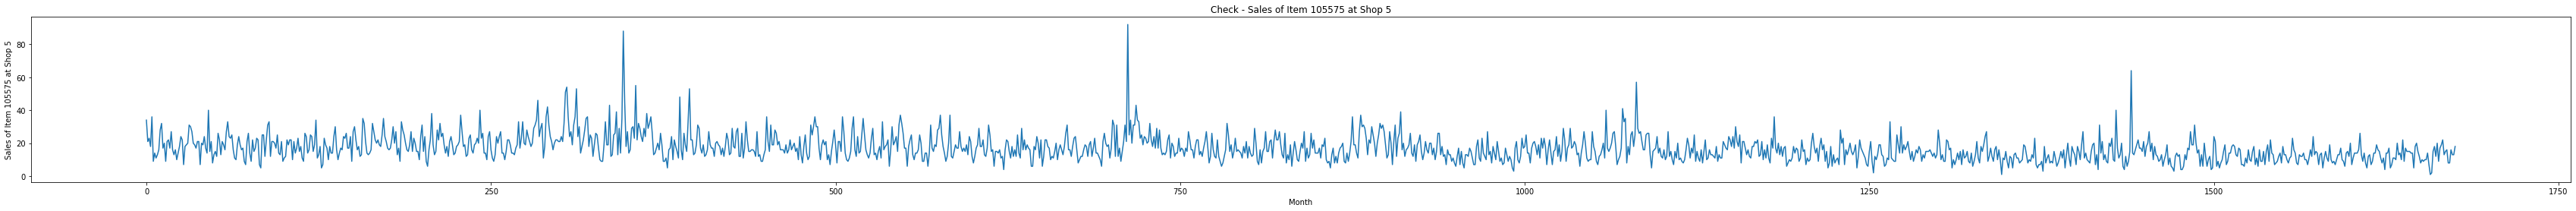

In [ ]:
plt.figure(figsize=(60,4))
plt.title('Check - Sales of Item 105575 at Shop 5')
plt.xlabel('Month')
plt.ylabel('Sales of Item 105575 at Shop 5')
plt.plot(list(range(len(check))),check["unit_sales"])

##Data Preprocessing

In [ ]:
seq = check.unit_sales.tolist()

#Make list of 5 time steps and obtain 6th
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

X,Y = split_sequence(seq,5)
for i in range(len(X)):
	print(X[i], Y[i])

x_train = X[:1253]
x_test= X[1253:]
y_train = Y[:1253]
y_test = Y[1253:]

[34. 21. 23. 18. 36.] 9.0
[21. 23. 18. 36.  9.] 14.0
[23. 18. 36.  9. 14.] 11.0
[18. 36.  9. 14. 11.] 13.0
[36.  9. 14. 11. 13.] 16.0
[ 9. 14. 11. 13. 16.] 28.0
[14. 11. 13. 16. 28.] 32.0
[11. 13. 16. 28. 32.] 17.0
[13. 16. 28. 32. 17.] 20.0
[16. 28. 32. 17. 20.] 9.0
[28. 32. 17. 20.  9.] 21.0
[32. 17. 20.  9. 21.] 22.0
[17. 20.  9. 21. 22.] 17.0
[20.  9. 21. 22. 17.] 27.0
[ 9. 21. 22. 17. 27.] 16.0
[21. 22. 17. 27. 16.] 13.0
[22. 17. 27. 16. 13.] 16.0
[17. 27. 16. 13. 16.] 10.0
[27. 16. 13. 16. 10.] 14.0
[16. 13. 16. 10. 14.] 18.0
[13. 16. 10. 14. 18.] 24.0
[16. 10. 14. 18. 24.] 22.0
[10. 14. 18. 24. 22.] 7.0
[14. 18. 24. 22.  7.] 18.0
[18. 24. 22.  7. 18.] 19.0
[24. 22.  7. 18. 19.] 20.0
[22.  7. 18. 19. 20.] 31.0
[ 7. 18. 19. 20. 31.] 30.0
[18. 19. 20. 31. 30.] 27.0
[19. 20. 31. 30. 27.] 20.0
[20. 31. 30. 27. 20.] 19.0
[31. 30. 27. 20. 19.] 17.0
[30. 27. 20. 19. 17.] 21.0
[27. 20. 19. 17. 21.] 21.0
[20. 19. 17. 21. 21.] 7.0
[19. 17. 21. 21.  7.] 20.0
[17. 21. 21.  7. 20.] 19.0
[21. 

In [ ]:
#Normalize Data
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(-1, 1))
x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.reshape((x_test.shape[0],x_test.shape[1],1))
x_train.shape

##Building the Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

#Construct RNN connected to ANN
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(5,1)))
model.add(Dropout(.1))
model.add(Dense(120))
model.add(Dropout(.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



##Training the Model

In [ ]:
#Fit model parameters to data
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,epochs=200)

In [ ]:
#Write the model weights to a file
model.save('rnn.h5')

##Testing the Model

####Load the Model

In [ ]:
from keras.models import load_model
model = load_model('rnn.h5')







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




####Run inference over model

In [ ]:
a = y_test.tolist()
b = model.predict(x_test).tolist()

####Evaluating Test Results

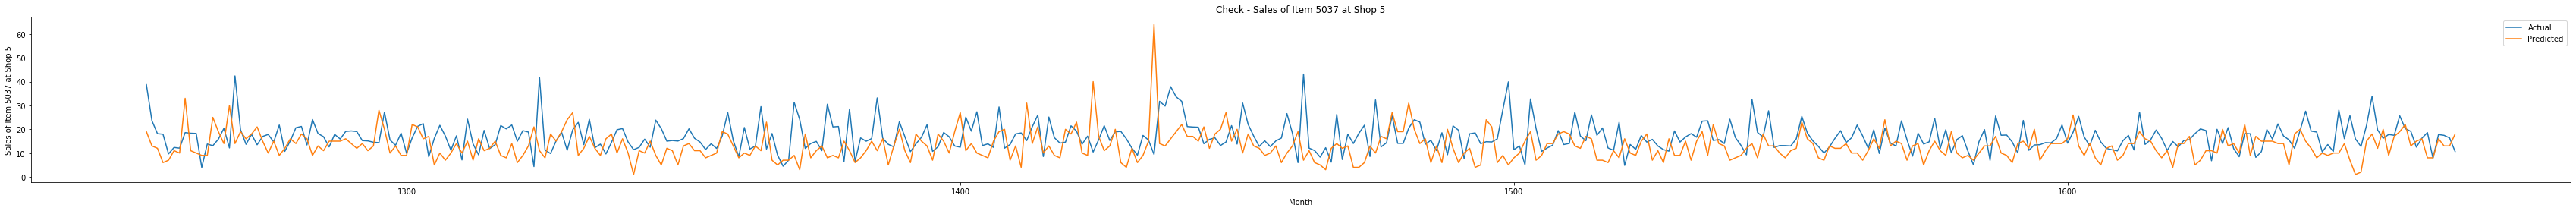

In [ ]:
#Plot graph of Actual and Predicted sales
plt.figure(figsize=(60,4))
plt.title('Check - Sales of Item 5037 at Shop 5')
plt.xlabel('Month')
plt.ylabel('Sales of Item 5037 at Shop 5')
plt.plot(range(len(x_train),len(X)),a,label="Actual")
plt.plot(range(len(x_train),len(X)),y_test.tolist(),label="Predicted")
plt.legend()



---

